Content:
- Data ETL:
    - check and manipulate missing values: use intro-quote information to filling missing values
    - check outliers
    - check if markup on same quote are similar. This decide if I can Aggregate to Quote-Level.
    - check data distribution, if I need to treat features with non-normal distribution  
    - convert date  
- Deep Dive of Data (EDA)
    - Check feature distribution
    - Check feature relation
    - Build relation to check feature importance
- Create Quote-leve; Features (Pipeline)
    - create category and price features:
        - Quote Value Metrics
        - Category-Based Features: the percentage of the total quote value for each category; category markup
        - Mix & Diversity Features
    - Add time-based features from quote_publish_date
- Train Test data split
    - categorical encoding
    - numerical scale
- model selection (CV)
    - logistic regression
    - lightBGM
    - XGBoost
- Fine Tuning model (CV)
- Evaluation
    - Confusion
    - AUC
- Pricing Optimization Framework
    - Markup Matrix
    - Grid Search engine
- Testing and visualization
- Furture work suggestion

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

In [2]:
df=pd.read_csv("./dataset.csv")

In [3]:
df.shape

(1000, 10)

In [4]:
df.head(5)

,quote_id,item_id,supplier_unit_price,quantity,product_category,quote_type,region,markup,quote_converted,quote_publish_date
0,Q12001,ItemID038,134.50,24.0,Networking,quote to order (QTO),Asia-Pacific,0.37,0,2023-05-22T22:19:32
1,Q12001,ItemID071,114.71,5.0,Storage,quote to order (QTO),Asia-Pacific,0.36,0,2023-05-22T22:19:32
2,Q12001,ItemID036,61.03,4.0,Networking,quote to order (QTO),Asia-Pacific,0.39,0,2023-05-22T22:19:32
3,Q12001,ItemID100,88.72,16.0,Storage,quote to order (QTO),Asia-Pacific,0.39,0,2023-05-22T22:19:32
4,Q12001,ItemID062,150.82,25.0,Compute,quote to order (QTO),Asia-Pacific,0.37,0,2023-05-22T22:19:32


In [5]:
col_example=[	'product_category',
             #'item_id',	
             'quote_type',	'region',	'quote_converted'
             #,'quote_publish_date'
            ]

In [6]:
for column in col_example:
    print(f"\n{column}: {df[column].nunique()} unique values")
    print(df[column].unique())


product_category: 3 unique values
['Networking' 'Storage' 'Compute' nan]

quote_type: 2 unique values
['quote to order (QTO)' 'normal quote' nan]

region: 3 unique values
['Asia-Pacific' 'Europe' 'North America' nan]

quote_converted: 2 unique values
[0 1]


In [7]:
df.isna().sum()

quote_id                0
item_id                 0
supplier_unit_price    30
quantity                8
product_category        7
quote_type              7
region                  7
markup                  6
quote_converted         0
quote_publish_date      6
dtype: int64

In [8]:
df_tran=df.copy()

In [9]:
# define 7 columns and fill missing value using data from the same quote
# Numerical columns: fill with the median of the quote group
# Categorical columns and date: fill with the mode of the quote group
columns_to_fill = [
    'supplier_unit_price', 'quantity', 'product_category', 
    'quote_type', 'region', 'markup', 'quote_publish_date'
]

for column in columns_to_fill:
    if column in ['supplier_unit_price', 'quantity', 'markup']:
        
        df_tran[column] = df_tran.groupby('quote_id')[column].transform(
            lambda x: x.fillna(x.median())
        )


    elif column in ['product_category', 'quote_type', 'region', 'quote_publish_date']:
        df_tran[column] = df_tran.groupby('quote_id')[column].transform(
            lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
        )

In [10]:
df_tran.isna().sum()

quote_id               0
item_id                0
supplier_unit_price    0
quantity               0
product_category       0
quote_type             0
region                 0
markup                 0
quote_converted        0
quote_publish_date     0
dtype: int64

In [11]:
(df_tran == 'Unknown').sum()

quote_id               0
item_id                0
supplier_unit_price    0
quantity               0
product_category       0
quote_type             0
region                 0
markup                 0
quote_converted        0
quote_publish_date     0
dtype: int64

In [12]:
df_tran['quote_publish_date']=pd.to_datetime(df_tran['quote_publish_date'])

In [13]:
df_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   quote_id             1000 non-null   object        
 1   item_id              1000 non-null   object        
 2   supplier_unit_price  1000 non-null   float64       
 3   quantity             1000 non-null   float64       
 4   product_category     1000 non-null   object        
 5   quote_type           1000 non-null   object        
 6   region               1000 non-null   object        
 7   markup               1000 non-null   float64       
 8   quote_converted      1000 non-null   int64         
 9   quote_publish_date   1000 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 78.3+ KB


Original quote level label and features: 	'quote_type',	'region',	'quote_converted', 'quote_publish_date'

In [14]:
df_tran.head(10)

,quote_id,item_id,supplier_unit_price,quantity,product_category,quote_type,region,markup,quote_converted,quote_publish_date
0,Q12001,ItemID038,134.50,24.0,Networking,quote to order (QTO),Asia-Pacific,0.37,0,2023-05-22 22:19:32
1,Q12001,ItemID071,114.71,5.0,Storage,quote to order (QTO),Asia-Pacific,0.36,0,2023-05-22 22:19:32
2,Q12001,ItemID036,61.03,4.0,Networking,quote to order (QTO),Asia-Pacific,0.39,0,2023-05-22 22:19:32
3,Q12001,ItemID100,88.72,16.0,Storage,quote to order (QTO),Asia-Pacific,0.39,0,2023-05-22 22:19:32
4,Q12001,ItemID062,150.82,25.0,Compute,quote to order (QTO),Asia-Pacific,0.37,0,2023-05-22 22:19:32
5,Q12001,ItemID053,63.38,32.0,Compute,quote to order (QTO),Asia-Pacific,0.37,0,2023-05-22 22:19:32
6,Q12001,ItemID099,79.85,14.0,Storage,quote to order (QTO),Asia-Pacific,0.37,0,2023-05-22 22:19:32
7,Q12001,ItemID043,54.67,28.0,Compute,quote to order (QTO),Asia-Pacific,0.37,0,2023-05-22 22:19:32
8,Q12001,ItemID056,124.44,4.0,Networking,quote to order (QTO),Asia-Pacific,0.38,0,2023-05-22 22:19:32
9,Q12002,ItemID010,81.45,3.0,Compute,normal quote,Europe,0.18,1,2024-04-22 17:57:34


In [15]:
region_check = df_tran.groupby('quote_id')['region'].agg([
    ('unique_regions', 'nunique'),
    ('region_list', lambda x: list(x.unique()))
]).reset_index()

# Filter quotes with multiple regions
region_check[region_check['unique_regions'] > 1]

,quote_id,unique_regions,region_list


### 1. Create Quote-level Features

1.1  Quote Value Metrics

In [16]:
#item cost
df_tran['item_cost'] = df_tran['quantity'] * df_tran['supplier_unit_price']

# Weighted markup numerator = sum(cost * markup)
weighted_markup_num = (df_tran['item_cost'] * df_tran['markup']).groupby(df_tran['quote_id']).sum()

# Weighted markup denominator = sum(cost)
weighted_markup_den = df_tran['item_cost'].groupby(df_tran['quote_id']).sum()

weighted_avg_markup = (weighted_markup_num / weighted_markup_den).reset_index(name='avg_markup')
# Group by quote_id and compute features
quote_features = df_tran.groupby('quote_id').agg(
    quote_converted	=('quote_converted','first'),
    quote_publish_date	=('quote_publish_date','first'),
    region	=('region','first'),
    quote_type	=('quote_type','first'),
    unique_items=('item_id', 'nunique'),
    unique_categories=('product_category', 'nunique'),
    total_units=('quantity', 'sum'),
    #avg_markup=('markup', 'mean'),
    max_markup=('markup', 'max'),
    min_markup=('markup', 'min'),
    markup_std=('markup', 'std'),

).reset_index()


# Merge weighted avg markup
quote_features = quote_features.merge(weighted_avg_markup, on='quote_id', how='left')

# Calculate total_cost correctly (supplier_unit_price * quantity) 
total_cost_calc = (df_tran['quantity'] * df_tran['supplier_unit_price']).groupby(df_tran['quote_id']).sum().reset_index(name='total_cost')

# # Calculate total_quote_value correctly (including quantity and markup) 
# quote_value_calc = (df_tran['quantity'] * df_tran['supplier_unit_price'] * (1 + df_tran['markup'])).groupby(df_tran['quote_id']).sum().reset_index(name='total_quote_value')

# Merge all calculations
quote_features = quote_features.merge(total_cost_calc, on='quote_id')
# quote_features = quote_features.merge(quote_value_calc, on='quote_id')
quote_features['avg_unit_cost'] = (
    quote_features['total_cost'] / quote_features['total_units'].replace(0, np.nan)
)

1.2 Category-Based Features (Calculate value ratios for each category: category value/quote value)

In [17]:
# Add category-specific features

for category in df_tran['product_category'].dropna().unique():
    category_mask = df_tran['product_category'] == category
    category_df = df_tran[category_mask].copy()
    
    # Compute item-level cost inside category
    category_df['item_cost'] = category_df['quantity'] * category_df['supplier_unit_price']
    
    # Item count per category
    item_count = (
        category_df.groupby('quote_id')['item_id']
        .count()
        .reset_index(name=f'{category}_item_count')
    )
    quote_features = quote_features.merge(item_count, on='quote_id', how='left')
    quote_features[f'{category}_item_count'] = quote_features[f'{category}_item_count'].fillna(0)
    
    # Total cost per category
    category_cost = (
        category_df.groupby('quote_id')['item_cost']
        .sum()
        .reset_index(name=f'{category}_total_cost')
    )
    quote_features = quote_features.merge(category_cost, on='quote_id', how='left')
    quote_features[f'{category}_total_cost'] = quote_features[f'{category}_total_cost'].fillna(0)

    # Weighted category markup
    weighted_markup_num = (
        (category_df['item_cost'] * category_df['markup'])
        .groupby(category_df['quote_id']).sum()
    )
    weighted_markup_den = (
        category_df['item_cost']
        .groupby(category_df['quote_id']).sum()
    )

    weighted_avg_markup = (weighted_markup_num / weighted_markup_den).reset_index(name=f'{category}_avg_markup')

    # Merge weighted markup (fill missing with 0 for quotes without that category)
    quote_features = quote_features.merge(weighted_avg_markup, on='quote_id', how='left')
    quote_features[f'{category}_avg_markup'] = quote_features[f'{category}_avg_markup'].fillna(0)

# Safe cost ratios
for category in df_tran['product_category'].dropna().unique():
    quote_features[f'{category}_cost_ratio'] = np.where(
        quote_features['total_cost'] == 0,
        0,
        quote_features[f'{category}_total_cost'] / quote_features['total_cost']
    )


1.3 Mix & Diversity Features

In [18]:
# Add mix features
quote_features['units_per_item'] = quote_features['total_units'] / quote_features['unique_items']
quote_features['markup_range'] = quote_features['max_markup'] - quote_features['min_markup']

1.4 Add time-based features from quote_publish_date

In [19]:

df_tran['quote_publish_date'] = pd.to_datetime(df_tran['quote_publish_date'])
time_features = df_tran.groupby('quote_id')['quote_publish_date'].first().reset_index()
time_features['quote_day_of_week'] = time_features['quote_publish_date'].dt.dayofweek
time_features['quote_month'] = time_features['quote_publish_date'].dt.month
time_features['quote_quarter'] = time_features['quote_publish_date'].dt.quarter
time_features['quote_year'] = time_features['quote_publish_date'].dt.year
time_features['is_month_end'] = time_features['quote_publish_date'].dt.is_month_end.astype(int)

quote_features = quote_features.merge(time_features[['quote_id', 'quote_day_of_week', 'quote_month', 'quote_quarter', 'quote_year','is_month_end']], on='quote_id', how='left')

1.5 calculate Gini diversity metrics  for quote Category Diversity and Product Diversity

In [20]:
# import numpy as np

# def gini_coefficient(values):
#     """Compute Gini coefficient for numeric array (e.g. cost or units)"""
#     values = np.array(values)
#     values = values[~np.isnan(values)]
#     if len(values) == 0:
#         return 0
#     sorted_vals = np.sort(values)
#     n = len(values)
#     cumvals = np.cumsum(sorted_vals)
#     gini = (n + 1 - 2 * np.sum(cumvals) / cumvals[-1]) / n
#     return gini

# diversity_metrics = df_tran.groupby('quote_id').agg(
#     cost_gini=('supplier_unit_price', gini_coefficient),
#     quantity_gini=('quantity', gini_coefficient)
# ).reset_index()
# # Merge everything together
# quote_features = quote_features.merge(diversity_metrics, on='quote_id', how='left')

In [21]:
quote_features

,quote_id,quote_converted,quote_publish_date,region,quote_type,unique_items,unique_categories,total_units,max_markup,min_markup,markup_std,avg_markup,total_cost,avg_unit_cost,Networking_item_count,Networking_total_cost,Networking_avg_markup,Storage_item_count,Storage_total_cost,Storage_avg_markup,Compute_item_count,Compute_total_cost,Compute_avg_markup,Networking_cost_ratio,Storage_cost_ratio,Compute_cost_ratio,units_per_item,markup_range,quote_day_of_week,quote_month,quote_quarter,quote_year,is_month_end
0,Q12001,0,2023-05-22 22:19:32,Asia-Pacific,quote to order (QTO),9,3,152.0,0.39,0.36,0.010138,0.372256,14410.27,94.804408,3.0,3969.88,0.372484,3.0,3110.97,0.377282,3.0,7329.42,0.370000,0.275490,0.215886,0.508625,16.888889,0.03,0,5,2,2023,0
1,Q12002,1,2024-04-22 17:57:34,Europe,normal quote,4,2,28.0,0.19,0.17,0.008165,0.181254,1693.15,60.469643,0.0,0.00,0.000000,3.0,1448.80,0.181466,1.0,244.35,0.180000,0.000000,0.855683,0.144317,7.000000,0.02,0,4,2,2024,0
2,Q12003,0,2023-02-15 23:37:50,Asia-Pacific,normal quote,6,2,70.0,0.38,0.36,0.010328,0.374999,4479.57,63.993857,3.0,2023.95,0.373881,3.0,2455.62,0.375920,0.0,0.00,0.000000,0.451818,0.548182,0.000000,11.666667,0.02,2,2,1,2023,0
3,Q12004,1,2025-05-05 04:12:41,North America,normal quote,7,3,123.0,0.29,0.27,0.008997,0.276621,8216.90,66.804065,2.0,2481.65,0.284445,2.0,2569.17,0.276018,3.0,3166.08,0.270977,0.302018,0.312669,0.385313,17.571429,0.02,0,5,2,2025,0
4,Q12005,1,2025-04-02 09:53:04,North America,normal quote,7,3,153.0,0.36,0.33,0.011073,0.344164,7513.99,49.111046,2.0,1905.34,0.334315,2.0,2301.30,0.337253,3.0,3307.35,0.354647,0.253572,0.306269,0.440159,21.857143,0.03,2,4,2,2025,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,Q12163,1,2024-06-26 04:47:14,Europe,normal quote,3,2,36.0,0.15,0.13,0.010000,0.141021,2748.42,76.345000,2.0,1920.00,0.137147,1.0,828.42,0.150000,0.0,0.00,0.000000,0.698583,0.301417,0.000000,12.000000,0.02,2,6,2,2024,0
163,Q12164,0,2023-03-03 10:12:02,North America,quote to order (QTO),8,3,135.0,0.17,0.15,0.009258,0.162721,11286.44,83.603259,3.0,7212.70,0.168698,3.0,2305.00,0.150000,2.0,1768.74,0.154925,0.639059,0.204227,0.156714,16.875000,0.02,4,3,1,2023,0
164,Q12165,1,2023-11-13 16:51:18,North America,normal quote,6,3,93.0,0.23,0.22,0.004082,0.229243,15501.20,166.679570,1.0,342.27,0.230000,3.0,2910.65,0.225969,2.0,12248.28,0.230000,0.022080,0.187769,0.790150,15.500000,0.01,0,11,4,2023,0
165,Q12166,1,2023-05-19 00:14:57,North America,quote to order (QTO),5,2,100.0,0.20,0.18,0.010954,0.187734,6402.14,64.021400,3.0,2939.04,0.196847,0.0,0.00,0.000000,2.0,3463.10,0.180000,0.459071,0.000000,0.540929,20.000000,0.02,4,5,2,2023,0


## 2. Data Exploration

### 2.0 key feature distribution

In [22]:
key_features=['quote_converted','unique_items',	'unique_categories',	'total_units',	'avg_unit_cost','avg_markup',	'markup_std',	'total_cost',	'markup_range',	'Networking_cost_ratio',	'Storage_cost_ratio',	'Compute_cost_ratio']

In [23]:
quote_features[key_features].describe()

,quote_converted,unique_items,unique_categories,total_units,avg_unit_cost,avg_markup,markup_std,total_cost,markup_range,Networking_cost_ratio,Storage_cost_ratio,Compute_cost_ratio
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,0.491018,5.988024,2.724551,106.419162,80.685699,0.258670,0.009155,8393.816557,0.021617,0.364572,0.306260,0.329168
std,0.501423,1.920053,0.461332,52.810166,25.616974,0.107020,0.002868,4559.926675,0.007470,0.244771,0.227398,0.243473
min,0.000000,3.000000,1.000000,18.000000,34.074970,0.072363,0.000000,1186.300000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,2.000000,62.000000,66.728186,0.163565,0.007714,4933.155000,0.020000,0.174963,0.124419,0.146522
50%,0.000000,6.000000,3.000000,102.000000,74.715455,0.273197,0.009574,7979.930000,0.020000,0.329126,0.285768,0.311166
75%,1.000000,8.000000,3.000000,143.000000,89.830726,0.354895,0.011100,10841.525000,0.030000,0.524219,0.461309,0.481869
max,1.000000,9.000000,3.000000,257.000000,260.550909,0.446719,0.015275,28271.200000,0.030000,0.977349,0.935572,1.000000


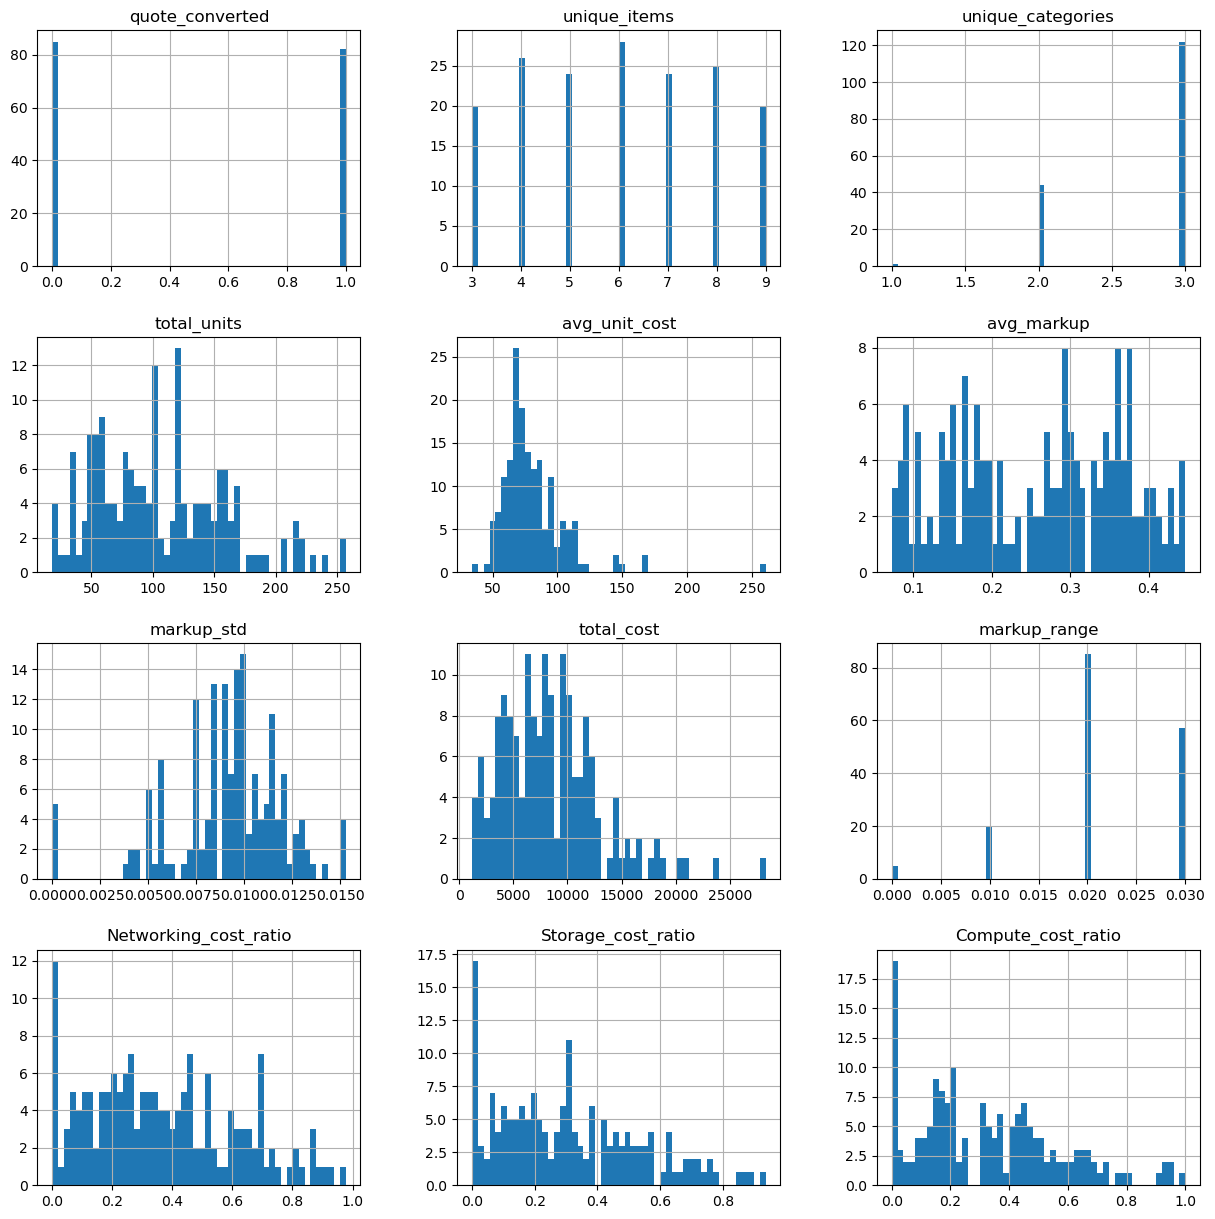

In [24]:
quote_features[key_features].hist(figsize=(15,15),bins=50)
plt.show()

## Insights- Feature Distribution

- Quotes are heterogeneous: `some small/simple, others large/diverse`.

- `Low markup variance within quotes`. this indicate is it useful for `summarizing per-quote averages`.

- `Category and product Gini might be strong of conversion` (diversity vs. focus of a quote).

- Right-skewed distributions (for cost and units) may want to log-transform them before modeling for certain model type.

<Figure size 2000x2000 with 0 Axes>

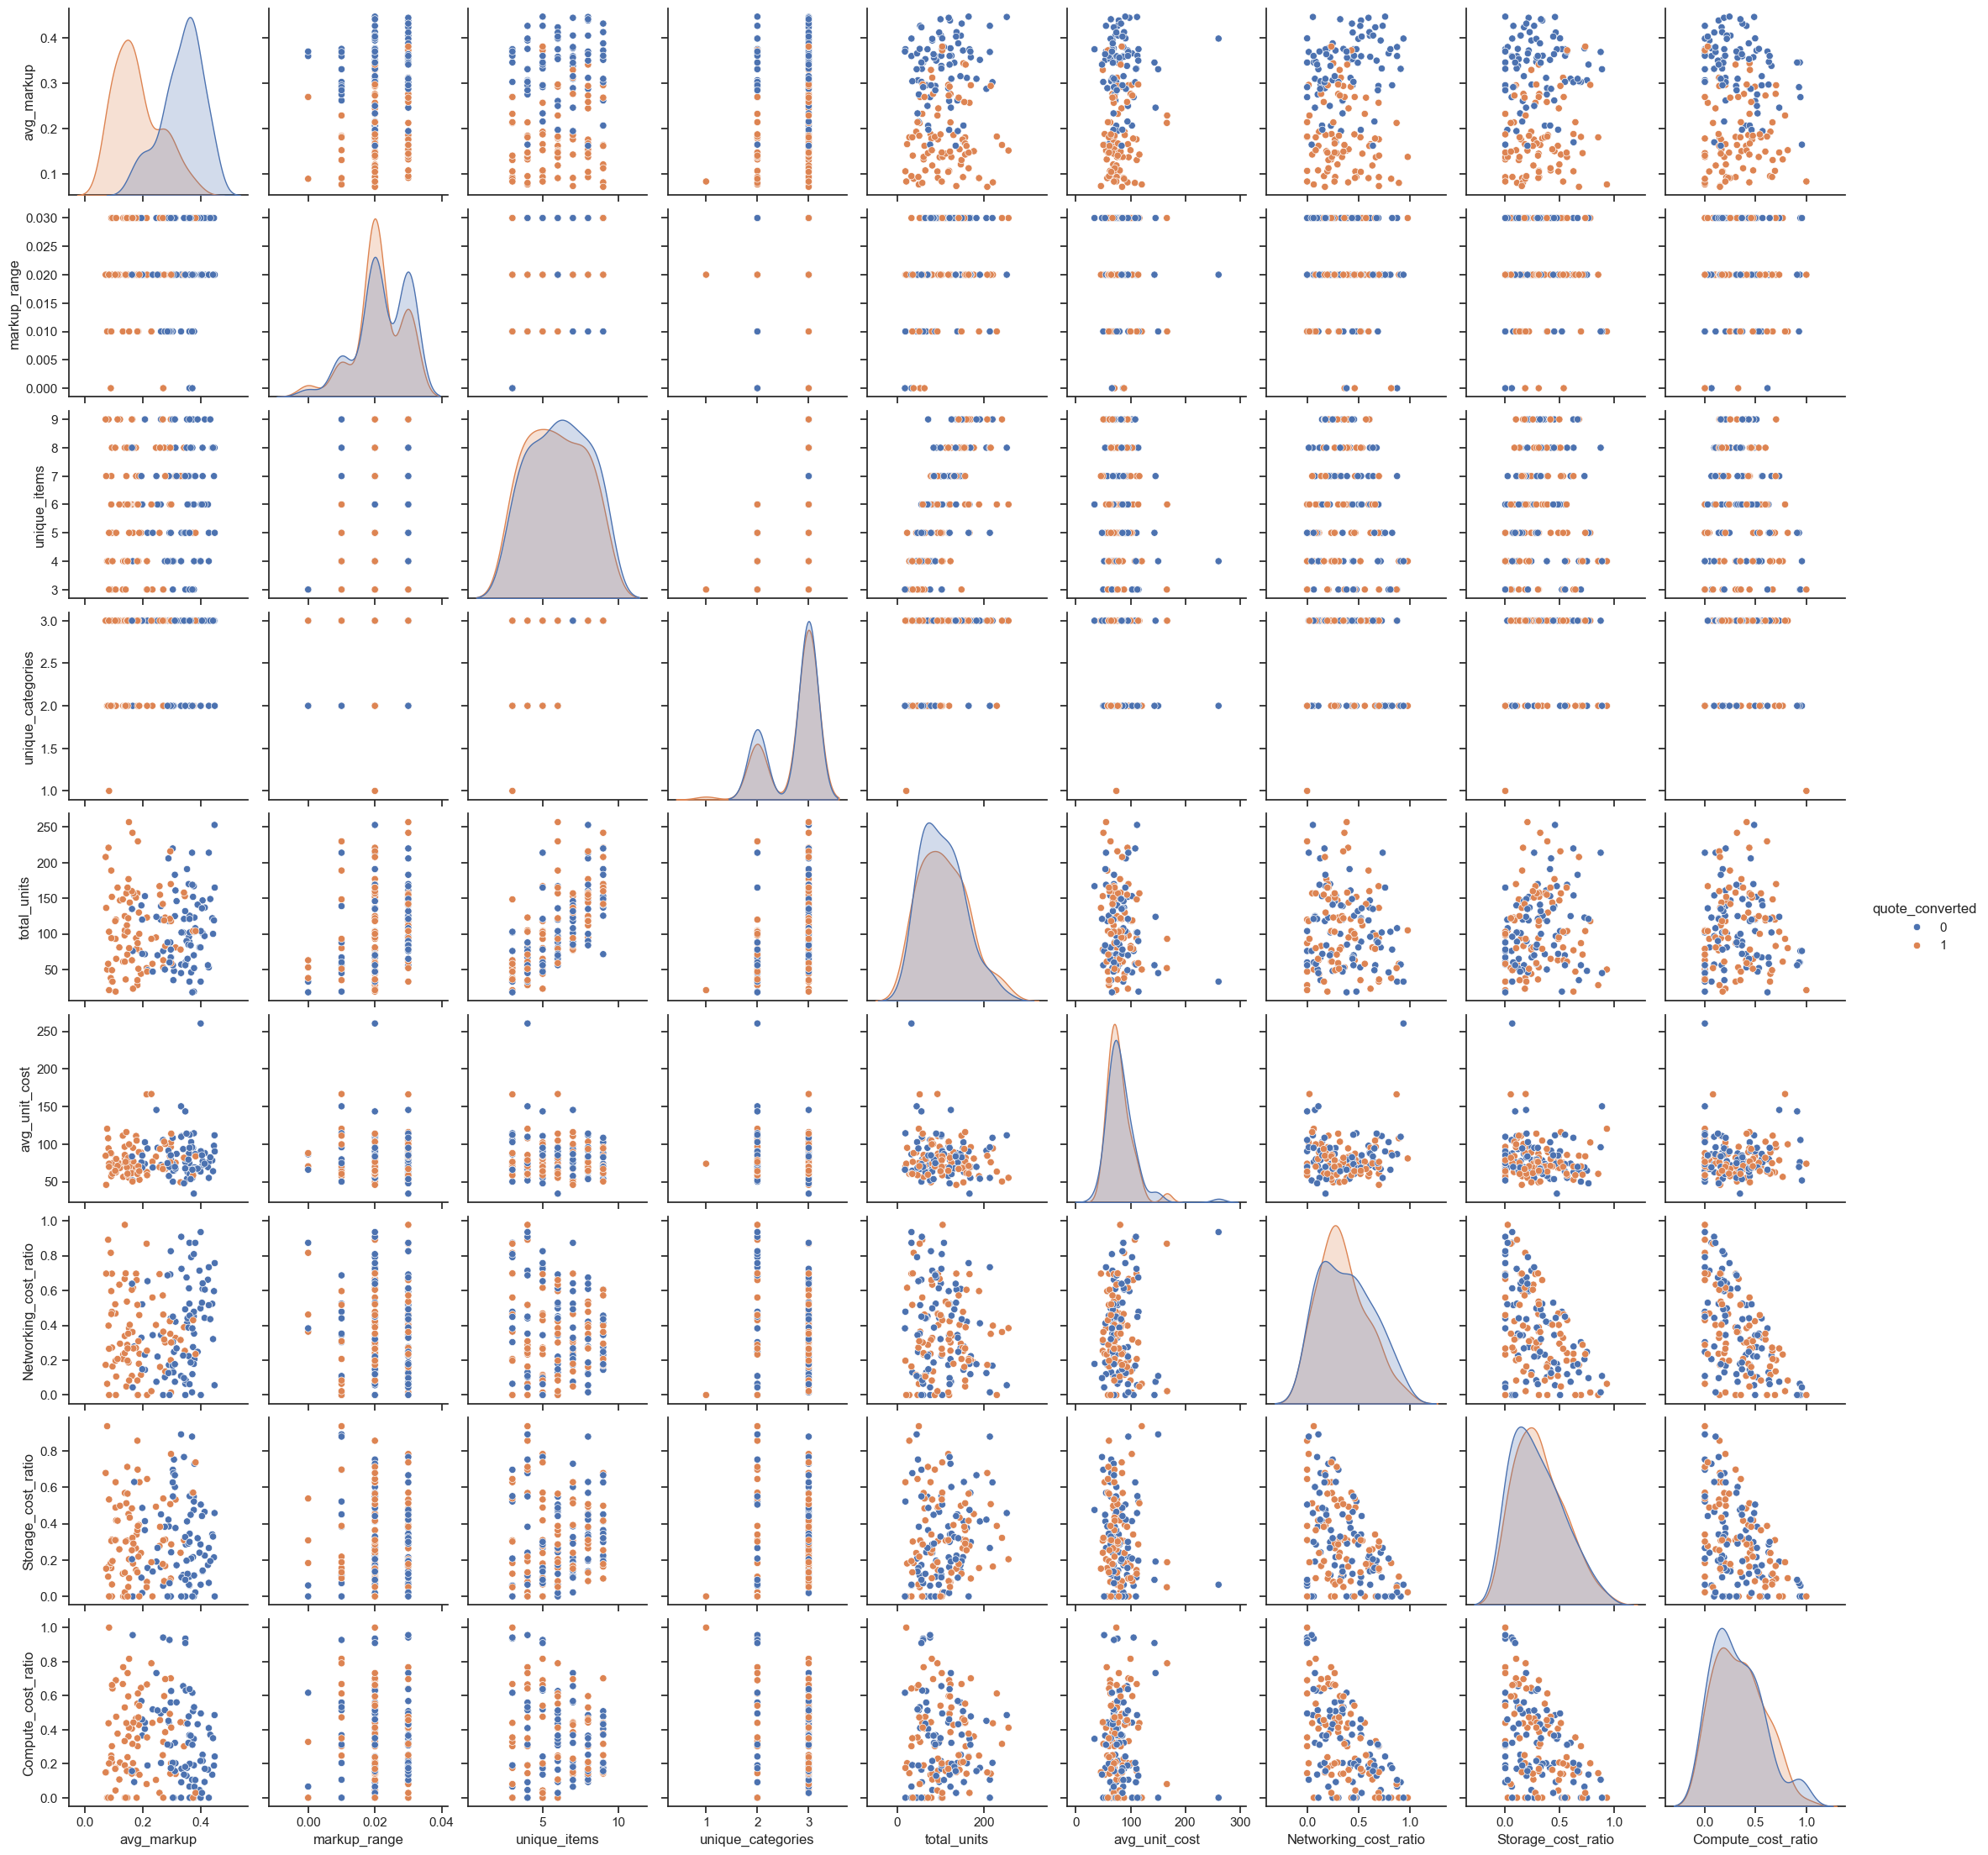

In [25]:
key_features_few=['quote_converted','avg_markup', 'markup_range','unique_items',	'unique_categories','total_units' ,'avg_unit_cost','Networking_cost_ratio',	'Storage_cost_ratio',	'Compute_cost_ratio']
sns.set(style='ticks')
plt.figure(figsize=(20,20))
sns.pairplot(quote_features[key_features_few],hue='quote_converted')
plt.show()

## Insights- Feature relation
1. Markup-Related Patterns

**Average Markup:average markup in one quote**

The density peaks show that successful quotes tend to cluster around smaller markups, while rejected quotes often have higher ones.
- `Interpretation: Lower pricing improves the likelihood of winning deals.`

**Markup Range: how markup varience in one quote**

Both classes have relatively small and overlapping markup ranges(most markup range<4%), but conversions occur slightly more often where the markup range is narrow (<2%).
- `Interpretation: More consistent pricing across items in the same quote (less variation of markup across items in one quote) may signal reliability or competitiveness to buyers.`

2. Product mix
Insight
- most quote has more than one category
- most quote has 4-6 items
- Networking focused quote (Networkking value>50%) is harder to convert   
- `Interpretation: Quotes offering a balanced combination of products may better meet client needs and thus convert more.`

3. Cross-Feature Relationships

avg_markup vs. value ratios:

- Higher markups often correspond to lower product mix ratios (especially compute and storage).

- No single product category dominates conversions, but `the best-performing quotes tend to avoid extreme ratios (e.g., 100% compute or 100% networking).`

### 2.1 Does lower Markups increase the chance of winning the deal? 

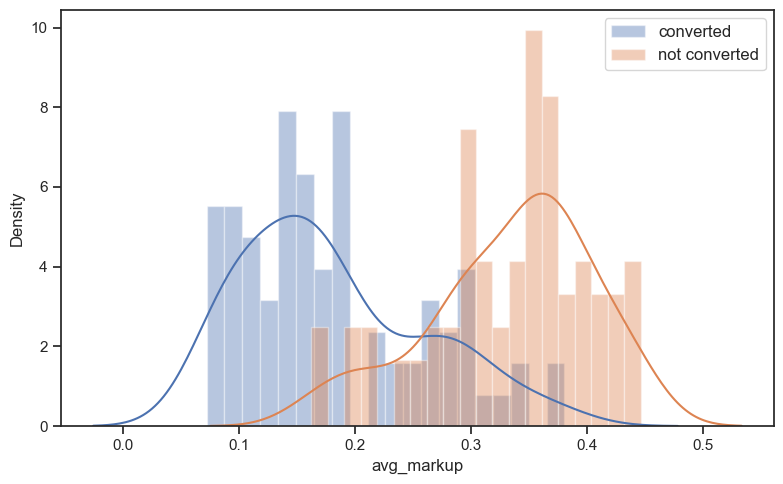

In [26]:
# visualization of Markup and conversion
fig, ax = plt.subplots(figsize=(8, 5))
sns.distplot(quote_features[quote_features['quote_converted']==True]['avg_markup'], label='converted', ax=ax,bins=20,kde=True)
sns.distplot(quote_features[quote_features['quote_converted']==False]['avg_markup'], label='not converted', ax=ax,bins=20,kde=True)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Insights- Markup vs Convert
- Converted quotes (blue) peak at lower markups, roughly around 0.10–0.20.
- Not converted quotes (orange) peak at higher markups, around 0.30–0.40.
- Mix convertion. Some overlap between the two distributions, around 0.20-0.30
  
- The chart suggests a strong negative relationship between markup and conversion — as markup increases, win rate decreases.

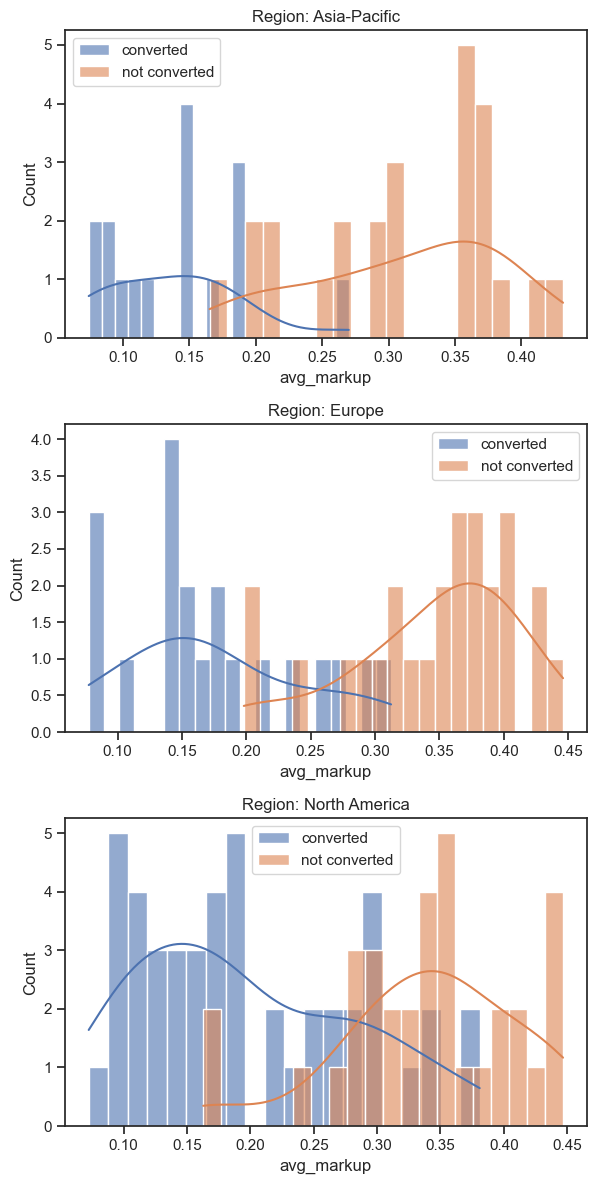

In [27]:

fig, axes = plt.subplots(3, 1, figsize=(6, 12))
axes = axes.ravel()

regions = quote_features['region'].explode().unique() 

for i, region in enumerate(regions):
    region_data = quote_features[quote_features['region'].apply(lambda x: region in x)]
    
    sns.histplot(region_data[region_data['quote_converted']==True]['avg_markup'], 
                 label='converted', ax=axes[i], bins=20, kde=True, alpha=0.6)
    sns.histplot(region_data[region_data['quote_converted']==False]['avg_markup'], 
                 label='not converted', ax=axes[i], bins=20, kde=True, alpha=0.6)
    axes[i].set_title(f'Region: {region}')
    axes[i].legend()

plt.tight_layout()
plt.show()

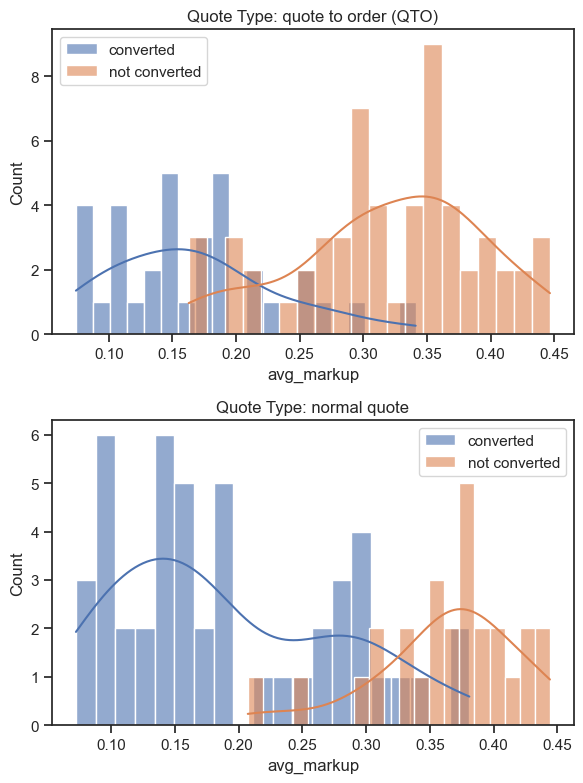

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(6, 8))
axes = axes.ravel()

quote_type = quote_features['quote_type'].unique()  # Remove .explode()

for i, qtype in enumerate(quote_type):
    # Fixed: use qtype instead of region in the lambda function
    type_data = quote_features[quote_features['quote_type'].apply(lambda x: qtype == x)]
    
    sns.histplot(type_data[type_data['quote_converted']==True]['avg_markup'], 
                 label='converted', ax=axes[i], bins=20, kde=True, alpha=0.6)
    sns.histplot(type_data[type_data['quote_converted']==False]['avg_markup'], 
                 label='not converted', ax=axes[i], bins=20, kde=True, alpha=0.6)
    axes[i].set_title(f'Quote Type: {qtype}')
    axes[i].legend()

plt.tight_layout()
plt.show()

### 2.2 Does convertion affected by 'region', 'quote_type',   'quote_quarter', 'is_month_end'

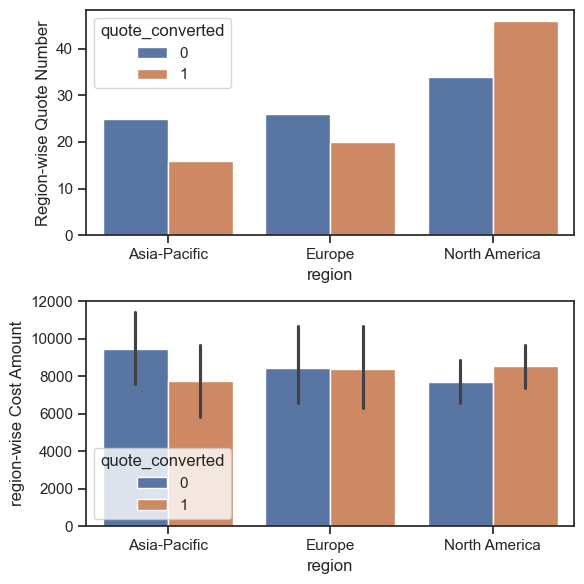

In [29]:
# region visualization 
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))
sns.countplot(x='region', hue='quote_converted', data=quote_features, ax=ax[0])
ax[0].set_ylabel('Region-wise Quote Number', fontsize=12)

sns.barplot(x='region', y='total_cost', hue='quote_converted', data=quote_features, ax=ax[1])
ax[1].set_ylabel('region-wise Cost Amount', fontsize=12)
plt.tight_layout()
plt.show()

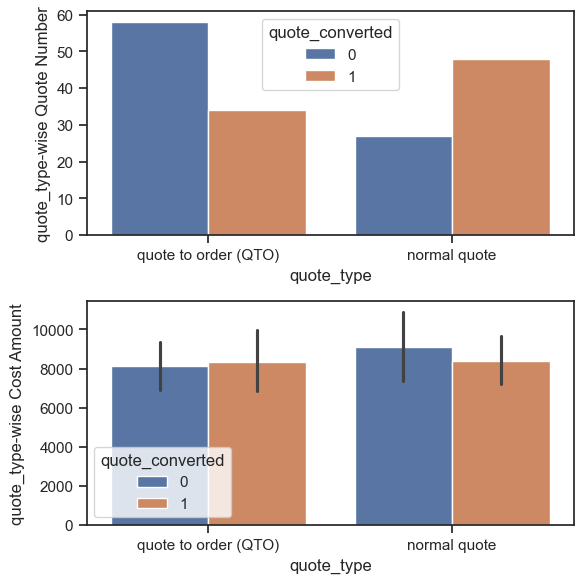

In [30]:
# region visualization 
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))
sns.countplot(x='quote_type', hue='quote_converted', data=quote_features, ax=ax[0])
ax[0].set_ylabel('quote_type-wise Quote Number', fontsize=12)

sns.barplot(x='quote_type', y='total_cost', hue='quote_converted', data=quote_features, ax=ax[1])
ax[1].set_ylabel('quote_type-wise Cost Amount', fontsize=12)
plt.tight_layout()
plt.show()

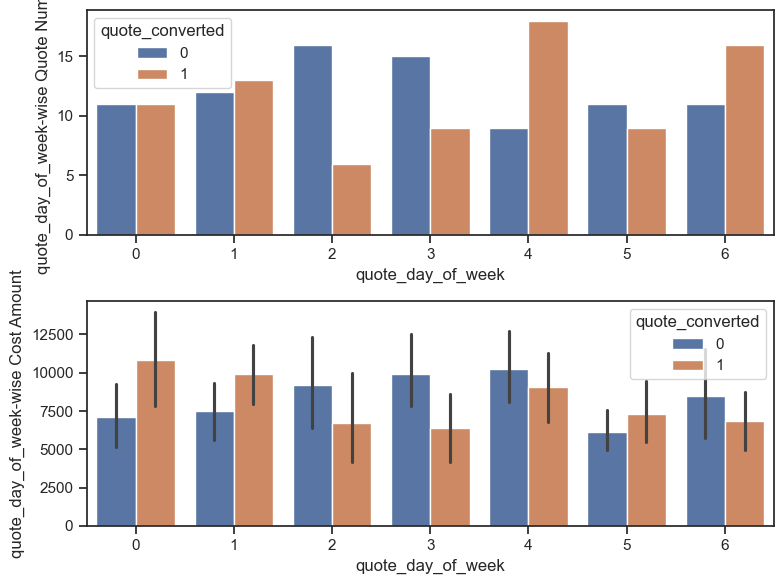

In [31]:
#quote_day_of_week visualization 
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
sns.countplot(x='quote_day_of_week', hue='quote_converted', data=quote_features, ax=ax[0])
ax[0].set_ylabel('quote_day_of_week-wise Quote Number', fontsize=12)

sns.barplot(x='quote_day_of_week', y='total_cost', hue='quote_converted', data=quote_features, ax=ax[1])
ax[1].set_ylabel('quote_day_of_week-wise Cost Amount', fontsize=12)
plt.tight_layout()
plt.show()

### 3. Answer the question: Model the relationship between pricing decisions and quote conversion

#### 3.1 Train-test Split

data has quote_publish_date, I split training and test sets chronologically, not randomly. This simulates how the model would behave in the real world (predicting future quotes based on past ones).

In [32]:
quote_features.shape

(167, 33)

In [33]:
quote_features.columns


Index(['quote_id', 'quote_converted', 'quote_publish_date', 'region',
       'quote_type', 'unique_items', 'unique_categories', 'total_units',
       'max_markup', 'min_markup', 'markup_std', 'avg_markup', 'total_cost',
       'avg_unit_cost', 'Networking_item_count', 'Networking_total_cost',
       'Networking_avg_markup', 'Storage_item_count', 'Storage_total_cost',
       'Storage_avg_markup', 'Compute_item_count', 'Compute_total_cost',
       'Compute_avg_markup', 'Networking_cost_ratio', 'Storage_cost_ratio',
       'Compute_cost_ratio', 'units_per_item', 'markup_range',
       'quote_day_of_week', 'quote_month', 'quote_quarter', 'quote_year',
       'is_month_end'],
      dtype='object')

In [34]:
categorical_feature=['region','quote_type']
# not select features require compute use markups
continuous_feature=[ 'total_units','avg_markup','markup_range','total_cost', 'avg_unit_cost', 'Networking_item_count',
       'Networking_total_cost', 'Networking_avg_markup', 'Storage_item_count',
       'Storage_total_cost', 'Storage_avg_markup', 'Compute_item_count',
       'Compute_total_cost', 'Compute_avg_markup', 'Networking_cost_ratio',
       'Storage_cost_ratio', 'Compute_cost_ratio', 'units_per_item',
       ]
discrete_feature=['unique_items', 'unique_categories','quote_day_of_week', 'quote_month', 'quote_quarter',
       'quote_year', 'is_month_end']

In [35]:
# Sort the dataset by quote_publish_date to ensure chronological order
quote_sort = quote_features.sort_values('quote_publish_date').copy()

# Define features and target
X = quote_sort[categorical_feature + discrete_feature + continuous_feature]
y = quote_sort[['quote_converted']].values

# Find the cutoff index for 80% oldest data
split_idx = int(len(quote_features) * 0.8)

# Split chronologically (no shuffling)
X_train_o = X.iloc[:split_idx]
X_test_o = X.iloc[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

print(X_train_o.shape, X_test_o.shape, y_train.shape, y_test.shape)

(133, 27) (34, 27) (133, 1) (34, 1)


#### 3.2 Standardize and one-hot encoding

In [36]:
import scipy
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

In [37]:
num_transformers = [('num', StandardScaler(), continuous_feature)]
cat_transformers = [('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore',drop='first' ), categorical_feature)]
column_tran = ColumnTransformer(transformers=cat_transformers + num_transformers,remainder='passthrough')

In [38]:
column_tran.fit(X_train_o)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['region', 'quote_type']),
                                ('num', StandardScaler(),
                                 ['total_units', 'avg_markup', 'markup_range',
                                  'total_cost', 'avg_unit_cost',
                                  'Networking_item_count',
                                  'Networking_total_cost',
                                  'Networking_avg_markup', 'Storage_item_count',
                                  'Storage_total_cost', 'Storage_avg_markup',
                                  'Compute_item_count', 'Compute_total_cost',
                                  'Compute_avg_markup', 'Networking_cost_ratio',
                                  'Storage_cost_ratio', 'Compute_cost_ratio',
                                  'units_per_item'])])

In [39]:
feature_names = column_tran.get_feature_names_out()
print(feature_names), print(len(feature_names))

['cat__region_Europe' 'cat__region_North America'
 'cat__quote_type_quote to order (QTO)' 'num__total_units'
 'num__avg_markup' 'num__markup_range' 'num__total_cost'
 'num__avg_unit_cost' 'num__Networking_item_count'
 'num__Networking_total_cost' 'num__Networking_avg_markup'
 'num__Storage_item_count' 'num__Storage_total_cost'
 'num__Storage_avg_markup' 'num__Compute_item_count'
 'num__Compute_total_cost' 'num__Compute_avg_markup'
 'num__Networking_cost_ratio' 'num__Storage_cost_ratio'
 'num__Compute_cost_ratio' 'num__units_per_item' 'remainder__unique_items'
 'remainder__unique_categories' 'remainder__quote_day_of_week'
 'remainder__quote_month' 'remainder__quote_quarter'
 'remainder__quote_year' 'remainder__is_month_end']
28


(None, None)

In [40]:
X_train = column_tran.transform(X_train_o)
X_test = column_tran.transform(X_test_o)
print(X_train.shape, X_test.shape)

(133, 28) (34, 28)


#### 3.3 CV Training & Validation and Scores for each model

In [41]:

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np

classifiers = [
    LogisticRegression(),
    RandomForestClassifier(),
    XGBClassifier()
]
classifier_names = [
    'LogisticRegression',
    'Random Forest Classifier', 
    'XGBoost'   
]

print("Model Comparison with Training & Validation Scores")
print("=" * 70)

for clf, clf_name in zip(classifiers, classifier_names):
    # Use cross_validate instead of cross_val_score to get both scores
    cv_results = cross_validate(
        clf, 
        X_train, 
        np.ravel(y_train), 
        cv=5,
        return_train_score=True,  # This gives training scores
        scoring='accuracy'
    )
    
    train_scores = cv_results['train_score']
    test_scores = cv_results['test_score']
    
    train_mean = round(train_scores.mean() * 100, 3)
    train_std = round(train_scores.std() * 100, 3)
    test_mean = round(test_scores.mean() * 100, 3) 
    test_std = round(test_scores.std() * 100, 3)
    gap = round((train_scores.mean() - test_scores.mean()) * 100, 3)
    
    print(f"{clf_name:25} | Train: {train_mean:6}% ± {train_std:5}% | "
          f"Test: {test_mean:6}% ± {test_std:5}% | Gap: {gap:5}%")

Model Comparison with Training & Validation Scores
LogisticRegression        | Train: 91.166% ± 0.455% | Test: 82.108% ± 8.781% | Gap: 9.057%
Random Forest Classifier  | Train:  100.0% ±   0.0% | Test: 81.994% ± 2.532% | Gap: 18.006%
XGBoost                   | Train:  100.0% ±   0.0% | Test: 83.561% ± 7.188% | Gap: 16.439%


Due to very limited observations, all 3 models have gaps in training and testing accuracy, indicating overfitting. This will improve as more data come in.
XGBoost model achieves the highest accuracy fore testing data.

#### 3.4 Hyperparameter Tuning - CV

In [42]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


# Define parameter grids

xgb_param_grid = {
    'n_estimators': [4, 5, 10, 20, 50],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],  # 'l1' works only with certain solvers
    'solver': ['lbfgs', 'liblinear'],  # 'liblinear' works for small data
    'max_iter': [200, 500]
}
# Perform GridSearch for each model

xgb_grid_search = GridSearchCV(
    estimator=XGBClassifier(random_state=123, use_label_encoder=False, eval_metric='logloss'),
    param_grid=xgb_param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

logreg_grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=123),
    param_grid=logreg_param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

# FIT THE MODELS

print("Fitting XGBoost...")
xgb_grid_search.fit(X_train, np.ravel(y_train))

print("Fitting Logistic Regression...")
logreg_grid_search.fit(X_train, np.ravel(y_train))

# Get best models
final_model_xgb = xgb_grid_search.best_estimator_
final_model_logreg = logreg_grid_search.best_estimator_

# Display best params
print("\nBest Parameters:")
print("XGBoost:", xgb_grid_search.best_params_)
print("Logistic Regression:", logreg_grid_search.best_params_)

Fitting XGBoost...
Fitting Logistic Regression...

Best Parameters:
XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Logistic Regression: {'C': 1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}


##### 3.5 Model Evaluation: Accuracy, Confusion Matrix, ROC curve

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, np.ravel(y_train), cv=5)
    print(f"{name} CV mean accuracy: {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%")
    
    # Fit and predict
    model.fit(X_train, np.ravel(y_train))
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Accuracy
    print(f"{name} Train Accuracy: {accuracy_score(y_train, y_train_pred)*100:.2f}%")
    print(f"{name} Test Accuracy: {accuracy_score(y_test, y_test_pred)*100:.2f}%")
    print("-" * 50)
    
    # ====== Confusion Matrix ======
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="YlGn", cbar=False)
    plt.title(f"{name} - Confusion Matrix (Test Data)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # ====== ROC Curve ======
    if hasattr(model, "predict_proba"):  # only models that support probabilities
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(5, 4))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=1)

        # Find the index of threshold closest to 0.5
        close_05 = np.argmin(np.abs(thresholds - 0.5))
        plt.plot(fpr[close_05 + 1], tpr[close_05 + 1], 'o',
                 markersize=10, fillstyle="none", c='k', mew=2,
                 label="threshold = 0.5")

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"{name} - ROC Curve")
        plt.legend(loc=4)
        plt.show()


XGBoost CV mean accuracy: 87.29% ± 4.95%
XGBoost Train Accuracy: 98.50%
XGBoost Test Accuracy: 85.29%
--------------------------------------------------


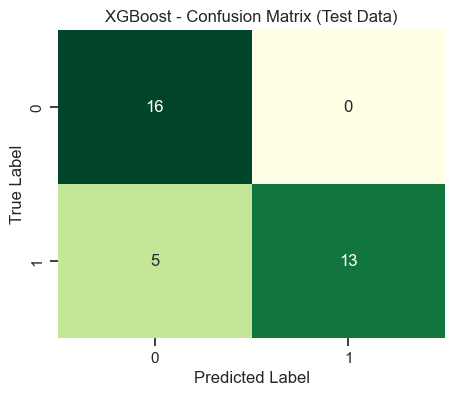

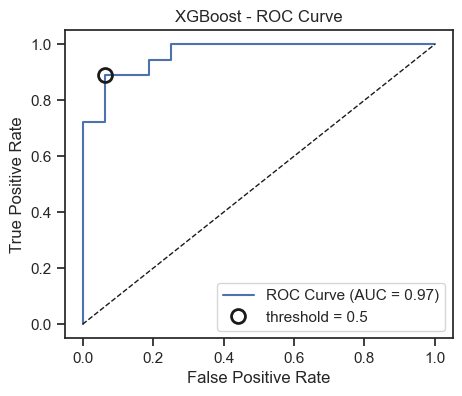

Logistic Regression CV mean accuracy: 84.30% ± 6.31%
Logistic Regression Train Accuracy: 92.48%
Logistic Regression Test Accuracy: 79.41%
--------------------------------------------------


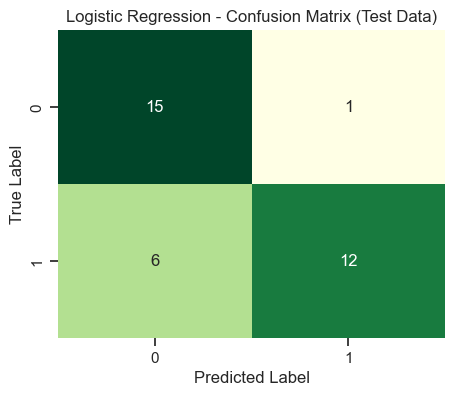

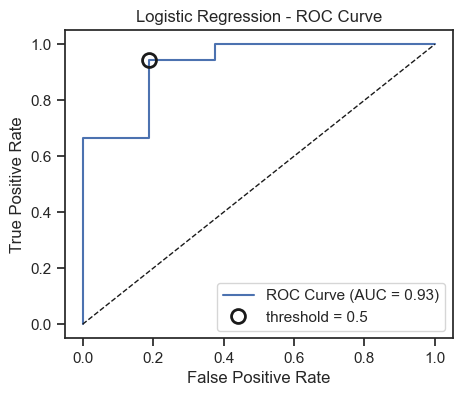

In [44]:
evaluate_model(final_model_xgb, X_train, y_train, X_test, y_test, "XGBoost")
evaluate_model(final_model_logreg, X_train, y_train, X_test, y_test, "Logistic Regression")

#### 3.6 SHAP check Feature Importance

In [45]:
import shap

In [46]:
explainer = shap.TreeExplainer(final_model_xgb)  # For tree-based models
shap_values = explainer.shap_values(X_test)

In [47]:

shap_values_positive = shap_values 
shap_df = pd.DataFrame(shap_values_positive, columns=feature_names)

# Mean absolute shap value per feature
shap_importance = np.abs(shap_values_positive).mean(axis=0)

shap_series = pd.Series(shap_importance, index=feature_names).sort_values(ascending=False)
print(shap_series)

num__avg_markup                         1.670074
cat__quote_type_quote to order (QTO)    0.565671
num__Compute_item_count                 0.278979
num__Networking_avg_markup              0.275335
num__Networking_cost_ratio              0.160220
num__Storage_total_cost                 0.150219
cat__region_North America               0.149790
remainder__quote_day_of_week            0.112341
num__total_units                        0.104552
remainder__quote_month                  0.092081
num__Compute_avg_markup                 0.076507
num__Storage_avg_markup                 0.064059
num__Storage_cost_ratio                 0.049608
num__units_per_item                     0.041075
num__Networking_total_cost              0.040242
num__Compute_cost_ratio                 0.039937
num__avg_unit_cost                      0.025232
remainder__unique_items                 0.022339
num__Compute_total_cost                 0.017882
num__total_cost                         0.017047
num__Networking_item

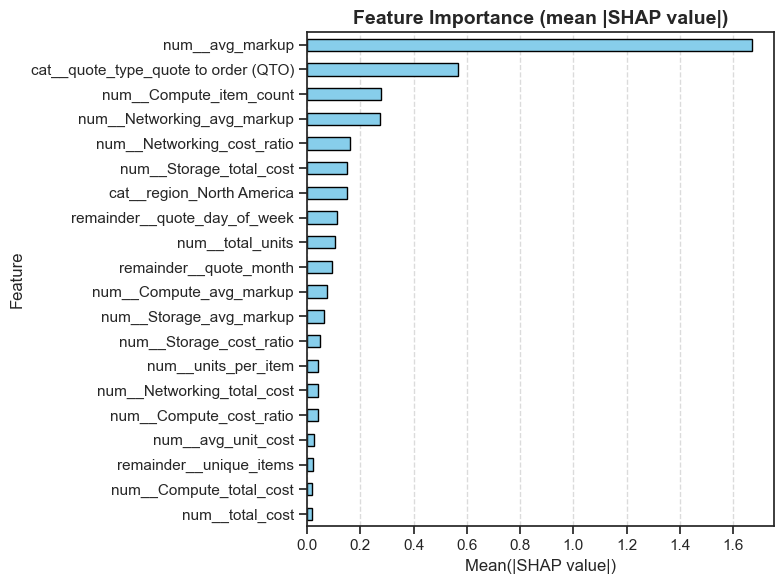

In [48]:
plt.figure(figsize=(8, 6))
shap_series.head(20).plot(
    kind='barh',
    color='skyblue',
    edgecolor='black'
)

plt.gca().invert_yaxis()  # Highest importance on top
plt.title("Feature Importance (mean |SHAP value|)", fontsize=14, weight='bold')
plt.xlabel("Mean(|SHAP value|)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Rank	Feature	Mean	
1	num__avg_markup (1.79)	Biggest driver — quotes with higher or lower average markup have the strongest influence on conversion probability.	
2	cat__quote_type_quote to order (QTO) (0.53)	The quote type (especially “quote to order”) significantly affects likelihood — possibly signals intent to purchase.	
3	num__Compute_avg_markup (0.45)	Within compute products, markup variations strongly affect conversion — pricing sensitivity in that category.	
4	num__Compute_item_count (0.24)	Larger or smaller compute item counts influence decisions (e.g., big bundles might get better discounts or lower conversion).	

- `Markup is the most critical lever — especially avg_markup and per-category markups (Compute_avg_markup etc.).`

- `Quote type and product mix (e.g., compute/storage proportions) matter a lot.`

- `Operational timing and region have secondary but noticeable effects — could be used for scheduling or targeting.`

Logistic Coef show impact direction

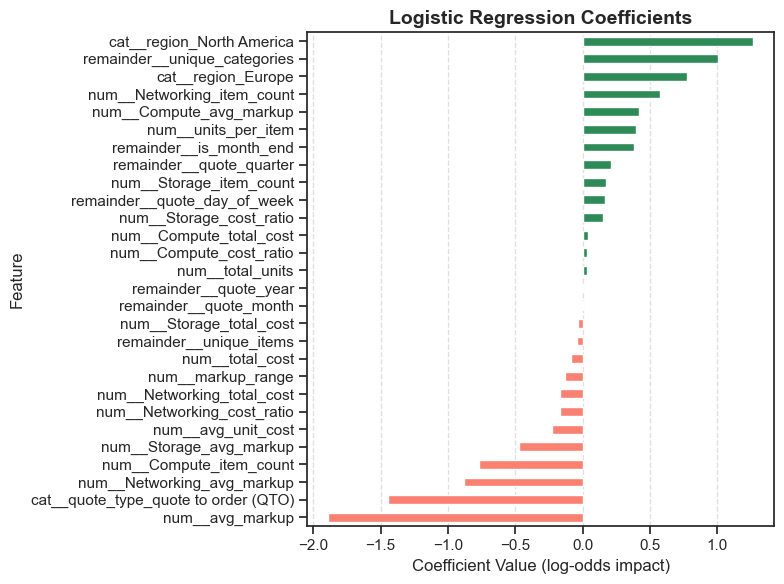

In [49]:
coef = final_model_logreg.coef_[0]
feature_importance = pd.Series(coef, index=feature_names).sort_values()

# Plot
plt.figure(figsize=(8, 6))
feature_importance.plot(kind='barh', color=np.where(feature_importance > 0, 'seagreen', 'salmon'))
plt.title("Logistic Regression Coefficients", fontsize=14, weight='bold')
plt.xlabel("Coefficient Value (log-odds impact)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [50]:
feature_importance

num__avg_markup                        -1.888382
cat__quote_type_quote to order (QTO)   -1.442848
num__Networking_avg_markup             -0.877916
num__Compute_item_count                -0.767061
num__Storage_avg_markup                -0.469503
num__avg_unit_cost                     -0.227058
num__Networking_cost_ratio             -0.171656
num__Networking_total_cost             -0.167883
num__markup_range                      -0.133084
num__total_cost                        -0.083717
remainder__unique_items                -0.043086
num__Storage_total_cost                -0.037898
remainder__quote_month                 -0.002834
remainder__quote_year                  -0.001806
num__total_units                        0.028736
num__Compute_cost_ratio                 0.035969
num__Compute_total_cost                 0.036060
num__Storage_cost_ratio                 0.148653
remainder__quote_day_of_week            0.166593
num__Storage_item_count                 0.172184
remainder__quote_qua

### 4.  Propose a strategy for setting markups across all items in a multi-product quotes, accounting for both profitability and the likelihood of winning the deal
### I build a profit simulation framework 

#### 4.1 Converstion Probability predict with matrix input

In [51]:
X_one = X.iloc[[split_idx]].copy()
X_experiment = column_tran.transform(X_one)
print(X_experiment.shape)

(1, 28)


In [52]:
X_one

,region,quote_type,unique_items,unique_categories,quote_day_of_week,quote_month,quote_quarter,quote_year,is_month_end,total_units,avg_markup,markup_range,total_cost,avg_unit_cost,Networking_item_count,Networking_total_cost,Networking_avg_markup,Storage_item_count,Storage_total_cost,Storage_avg_markup,Compute_item_count,Compute_total_cost,Compute_avg_markup,Networking_cost_ratio,Storage_cost_ratio,Compute_cost_ratio,units_per_item
16,North America,quote to order (QTO),9,3,0,12,4,2024,0,139.0,0.262312,0.01,10030.64,72.162878,3.0,3457.32,0.26,3.0,4523.01,0.265128,3.0,2050.31,0.26,0.344676,0.450919,0.204405,15.444444


In [53]:
quote_sort.iloc[[split_idx]]

,quote_id,quote_converted,quote_publish_date,region,quote_type,unique_items,unique_categories,total_units,max_markup,min_markup,markup_std,avg_markup,total_cost,avg_unit_cost,Networking_item_count,Networking_total_cost,Networking_avg_markup,Storage_item_count,Storage_total_cost,Storage_avg_markup,Compute_item_count,Compute_total_cost,Compute_avg_markup,Networking_cost_ratio,Storage_cost_ratio,Compute_cost_ratio,units_per_item,markup_range,quote_day_of_week,quote_month,quote_quarter,quote_year,is_month_end
16,Q12017,0,2024-12-09 17:46:32,North America,quote to order (QTO),9,3,139.0,0.27,0.26,0.00441,0.262312,10030.64,72.162878,3.0,3457.32,0.26,3.0,4523.01,0.265128,3.0,2050.31,0.26,0.344676,0.450919,0.204405,15.444444,0.01,0,12,4,2024,0


In [54]:
import numpy as np
import itertools
import pandas as pd

# Define value ranges for each category
networking_vals = np.arange(0.1, 0.41, 0.05)
storage_vals    = np.arange(0.1, 0.41, 0.05)
compute_vals    = np.arange(0.1, 0.41, 0.05)

# All combinations of the 3 markup values
combos = list(itertools.product(networking_vals, storage_vals, compute_vals))

# Make a DataFrame of all combinations
combo_df = pd.DataFrame(combos, columns=[
    'Networking_avg_markup', 'Storage_avg_markup', 'Compute_avg_markup'
])

In [55]:
net_ratio = X_one['Networking_cost_ratio'].values[0]
sto_ratio = X_one['Storage_cost_ratio'].values[0]
com_ratio = X_one['Compute_cost_ratio'].values[0]

In [56]:
#build weighted_quote_avg_markup
combo_df['avg_markup'] = (
      combo_df['Networking_avg_markup'] * net_ratio
    + combo_df['Storage_avg_markup']    * sto_ratio
    + combo_df['Compute_avg_markup']    * com_ratio
)

In [57]:
combo_df

,Networking_avg_markup,Storage_avg_markup,Compute_avg_markup,avg_markup
0,0.1,0.1,0.10,0.100000
1,0.1,0.1,0.15,0.110220
2,0.1,0.1,0.20,0.120440
3,0.1,0.1,0.25,0.130661
4,0.1,0.1,0.30,0.140881
...,...,...,...,...
338,0.4,0.4,0.20,0.359119
339,0.4,0.4,0.25,0.369339
340,0.4,0.4,0.30,0.379560
341,0.4,0.4,0.35,0.389780


In [58]:
# Repeat the base row for each combination
X_sim = pd.concat([X_one]*len(combo_df), ignore_index=True)

# Replace with new markup combinations
for col in ['Networking_avg_markup', 'Storage_avg_markup', 'Compute_avg_markup']:
    X_sim[col] = combo_df[col]

In [59]:
# Add the weighted quote average markup
X_sim['avg_markup'] = combo_df['avg_markup'].values

In [60]:
X_sim.shape

(343, 27)

In [61]:
X_sim.sample(5)

,region,quote_type,unique_items,unique_categories,quote_day_of_week,quote_month,quote_quarter,quote_year,is_month_end,total_units,avg_markup,markup_range,total_cost,avg_unit_cost,Networking_item_count,Networking_total_cost,Networking_avg_markup,Storage_item_count,Storage_total_cost,Storage_avg_markup,Compute_item_count,Compute_total_cost,Compute_avg_markup,Networking_cost_ratio,Storage_cost_ratio,Compute_cost_ratio,units_per_item
116,North America,quote to order (QTO),9,3,0,12,4,2024,0,139.0,0.220440,0.01,10030.64,72.162878,3.0,3457.32,0.20,3.0,4523.01,0.20,3.0,2050.31,0.3,0.344676,0.450919,0.204405,15.444444
6,North America,quote to order (QTO),9,3,0,12,4,2024,0,139.0,0.161321,0.01,10030.64,72.162878,3.0,3457.32,0.10,3.0,4523.01,0.10,3.0,2050.31,0.4,0.344676,0.450919,0.204405,15.444444
174,North America,quote to order (QTO),9,3,0,12,4,2024,0,139.0,0.280661,0.01,10030.64,72.162878,3.0,3457.32,0.25,3.0,4523.01,0.25,3.0,2050.31,0.4,0.344676,0.450919,0.204405,15.444444
139,North America,quote to order (QTO),9,3,0,12,4,2024,0,139.0,0.308519,0.01,10030.64,72.162878,3.0,3457.32,0.20,3.0,4523.01,0.35,3.0,2050.31,0.4,0.344676,0.450919,0.204405,15.444444
326,North America,quote to order (QTO),9,3,0,12,4,2024,0,139.0,0.334468,0.01,10030.64,72.162878,3.0,3457.32,0.40,3.0,4523.01,0.30,3.0,2050.31,0.3,0.344676,0.450919,0.204405,15.444444


In [62]:
X_sim_transformed = column_tran.transform(X_sim)

In [63]:
X_sim_transformed.shape

(343, 28)

In [64]:
y_pred_prob = final_model_xgb.predict_proba(X_sim_transformed)[:, 1]

In [65]:
results = combo_df.copy()
results['predicted_prob'] = y_pred_prob

In [66]:
best = results.sort_values('predicted_prob', ascending=False).head(10)
print(best)

    Networking_avg_markup  Storage_avg_markup  Compute_avg_markup  avg_markup  predicted_prob
57                   0.15                0.15                0.15    0.150000        0.946937
56                   0.15                0.15                0.10    0.139780        0.946937
50                   0.15                0.10                0.15    0.127454        0.946937
63                   0.15                0.20                0.10    0.162326        0.946937
14                   0.10                0.20                0.10    0.145092        0.946937
8                    0.10                0.15                0.15    0.132766        0.946937
7                    0.10                0.15                0.10    0.122546        0.946937
0                    0.10                0.10                0.10    0.100000        0.946937
49                   0.15                0.10                0.10    0.117234        0.946937
15                   0.10                0.20               

In [67]:
results.describe()

,Networking_avg_markup,Storage_avg_markup,Compute_avg_markup,avg_markup,predicted_prob
count,343.000000,343.000000,343.000000,343.000000,343.000000
mean,0.250000,0.250000,0.250000,0.250000,0.316519
std,0.100146,0.100146,0.100146,0.060413,0.261312
min,0.100000,0.100000,0.100000,0.100000,0.077660
25%,0.150000,0.150000,0.150000,0.206812,0.148682
50%,0.250000,0.250000,0.250000,0.250000,0.196447
75%,0.350000,0.350000,0.350000,0.293188,0.327894
max,0.400000,0.400000,0.400000,0.400000,0.946937


#### 4.2 optimize expected Margin framework
#### Expected margin =(total cost of the quote) × (weighted average markup across all categories) × (probability of winning the quote)
Expected Margin=(Total Cost)×[(Networking Markup×Networking Cost Ratio)+(Storage Markup×Storage Cost Ratio)+(Compute Markup×Compute Cost Ratio)]×(Predicted Quote Conversion Probability)

In [68]:
results['expected_margin'] = (
    X_one['total_cost'].values[0] *
    ((results['Networking_avg_markup'] * X_one['Networking_cost_ratio'].values[0]) +
     (results['Storage_avg_markup'] * X_one['Storage_cost_ratio'].values[0]) +
     (results['Compute_avg_markup'] * X_one['Compute_cost_ratio'].values[0]))
    * results['predicted_prob']
)
best = results.sort_values('expected_margin', ascending=False).head(10)

In [69]:
best

,Networking_avg_markup,Storage_avg_markup,Compute_avg_markup,avg_markup,predicted_prob,expected_margin
28,0.10,0.30,0.10,0.190184,0.903110,1722.831384
70,0.15,0.25,0.10,0.184872,0.903110,1674.709643
66,0.15,0.20,0.25,0.192986,0.859005,1662.841809
61,0.15,0.15,0.35,0.190881,0.859005,1644.700061
23,0.10,0.25,0.20,0.188078,0.859005,1620.552153
22,0.10,0.25,0.15,0.177858,0.903110,1611.175434
18,0.10,0.20,0.30,0.185973,0.859005,1602.410405
13,0.10,0.15,0.40,0.183867,0.859005,1584.268657
65,0.15,0.20,0.20,0.182766,0.859005,1574.780522
64,0.15,0.20,0.15,0.172546,0.903110,1563.053694


In [70]:
# Extract base cost and ratios
total_cost = X_one['total_cost'].values[0]

networking_ratio = X_one['Networking_cost_ratio'].values[0]
storage_ratio    = X_one['Storage_cost_ratio'].values[0]
compute_ratio    = X_one['Compute_cost_ratio'].values[0]

# Extract the actual markups from X_one
networking_markup = X_one['Networking_avg_markup'].values[0]
storage_markup    = X_one['Storage_avg_markup'].values[0]
compute_markup    = X_one['Compute_avg_markup'].values[0]

# (optional) predicted probability if you want expected margin, not pure margin
pred_prob = 1.0  # or from model.predict_proba(X_transformed)[0, 1]

# ✅ Calculate current expected margin
current_margin = total_cost * (
    (networking_markup * networking_ratio) +
    (storage_markup * storage_ratio) +
    (compute_markup * compute_ratio)
) * pred_prob

print(f"Current expected margin (no matter convert or not): ${current_margin:,.2f}")

Current expected margin (no matter convert or not): $2,631.16


In [71]:
X_one_transformed = column_tran.transform(X_one)
pred_prob = final_model_xgb.predict_proba(X_one_transformed)[0, 1]

current_margin = total_cost * (
    (networking_markup * networking_ratio) +
    (storage_markup * storage_ratio) +
    (compute_markup * compute_ratio)
) * pred_prob

print(f"Predicted Probability: {pred_prob:.3f}")
print(f"Expected Margin (with probability): ${current_margin:,.2f}")

Predicted Probability: 0.277
Expected Margin (with probability): $728.42


In [72]:
quote_sort.iloc[[split_idx]]

,quote_id,quote_converted,quote_publish_date,region,quote_type,unique_items,unique_categories,total_units,max_markup,min_markup,markup_std,avg_markup,total_cost,avg_unit_cost,Networking_item_count,Networking_total_cost,Networking_avg_markup,Storage_item_count,Storage_total_cost,Storage_avg_markup,Compute_item_count,Compute_total_cost,Compute_avg_markup,Networking_cost_ratio,Storage_cost_ratio,Compute_cost_ratio,units_per_item,markup_range,quote_day_of_week,quote_month,quote_quarter,quote_year,is_month_end
16,Q12017,0,2024-12-09 17:46:32,North America,quote to order (QTO),9,3,139.0,0.27,0.26,0.00441,0.262312,10030.64,72.162878,3.0,3457.32,0.26,3.0,4523.01,0.265128,3.0,2050.31,0.26,0.344676,0.450919,0.204405,15.444444,0.01,0,12,4,2024,0


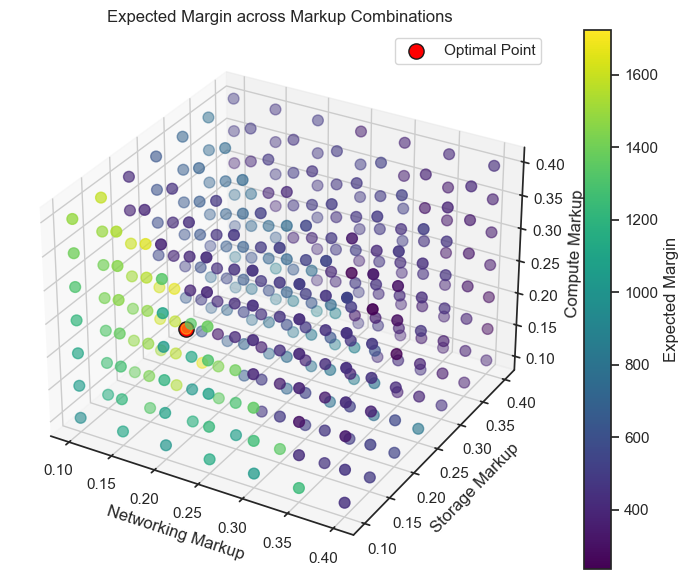

In [73]:
import seaborn as sns

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    results['Networking_avg_markup'],
    results['Storage_avg_markup'],
    results['Compute_avg_markup'],
    c=results['expected_margin'],
    cmap='viridis',
    s=60
)
best_idx = results['expected_margin'].idxmax()
best_row = results.loc[best_idx]
ax.scatter(best_row['Networking_avg_markup'],
           best_row['Storage_avg_markup'],
           best_row['Compute_avg_markup'],
           color='red', s=120, edgecolor='k', label='Optimal Point')

ax.set_xlabel('Networking Markup')
ax.set_ylabel('Storage Markup')
ax.set_zlabel('Compute Markup')
ax.set_title('Expected Margin across Markup Combinations')
plt.colorbar(sc, ax=ax, label='Expected Margin')
plt.legend()
plt.show()

Matched rows for Compute_avg_markup ≈ 0.15: 49


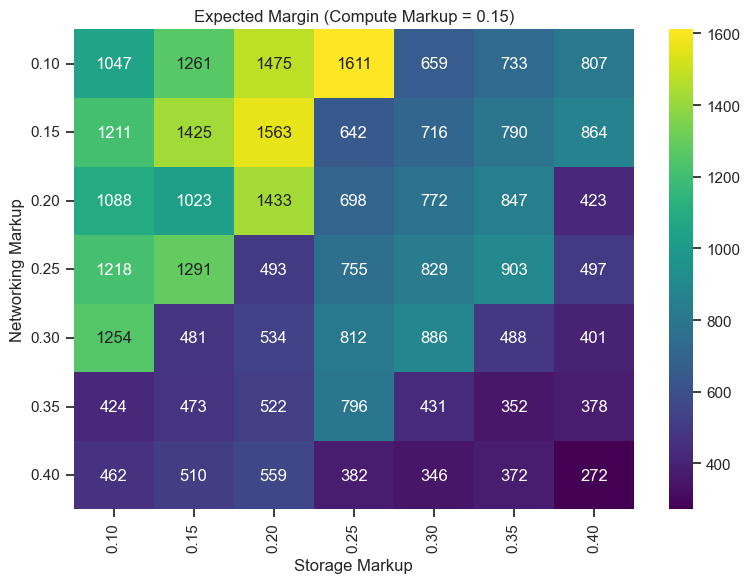

In [74]:

fixed_compute = 0.15

subset = results[np.isclose(results['Compute_avg_markup'], fixed_compute, atol=1e-6)]

print(f"Matched rows for Compute_avg_markup ≈ {fixed_compute}: {len(subset)}")

if subset.empty:
    print(f"No rows matched Compute_avg_markup ≈ {fixed_compute}. "
          f"Try rounding results first using results.round(2).")
else:
    # Create pivot table
    pivot = subset.pivot_table(
        index='Networking_avg_markup',
        columns='Storage_avg_markup',
        values='expected_margin'
    )

    plt.figure(figsize=(8,6))
    ax = sns.heatmap(
        pivot, annot=True, fmt=".0f", cmap='viridis'
    )

    ax.set_xticklabels([f"{x:.2f}" for x in pivot.columns])
    ax.set_yticklabels([f"{y:.2f}" for y in pivot.index])

    plt.title(f'Expected Margin (Compute Markup = {fixed_compute:.2f})')
    plt.xlabel('Storage Markup')
    plt.ylabel('Networking Markup')
    plt.tight_layout()
    plt.show()


In [75]:
import statsmodels.api as sm

X_cat = quote_features[['Compute_avg_markup','Storage_avg_markup','Networking_avg_markup','avg_markup']]
X_cat = sm.add_constant(X_cat)
y_cat = quote_features['quote_converted']
model = sm.Logit(y_cat, X_cat).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.366509
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        quote_converted   No. Observations:                  167
Model:                          Logit   Df Residuals:                      162
Method:                           MLE   Df Model:                            4
Date:                Thu, 13 Nov 2025   Pseudo R-squ.:                  0.4711
Time:                        08:43:35   Log-Likelihood:                -61.207
converged:                       True   LL-Null:                       -115.73
Covariance Type:            nonrobust   LLR p-value:                 1.164e-22
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.7671      0.856      6.740      0.000       4.090       7.

In [76]:
quote_features

,quote_id,quote_converted,quote_publish_date,region,quote_type,unique_items,unique_categories,total_units,max_markup,min_markup,markup_std,avg_markup,total_cost,avg_unit_cost,Networking_item_count,Networking_total_cost,Networking_avg_markup,Storage_item_count,Storage_total_cost,Storage_avg_markup,Compute_item_count,Compute_total_cost,Compute_avg_markup,Networking_cost_ratio,Storage_cost_ratio,Compute_cost_ratio,units_per_item,markup_range,quote_day_of_week,quote_month,quote_quarter,quote_year,is_month_end
0,Q12001,0,2023-05-22 22:19:32,Asia-Pacific,quote to order (QTO),9,3,152.0,0.39,0.36,0.010138,0.372256,14410.27,94.804408,3.0,3969.88,0.372484,3.0,3110.97,0.377282,3.0,7329.42,0.370000,0.275490,0.215886,0.508625,16.888889,0.03,0,5,2,2023,0
1,Q12002,1,2024-04-22 17:57:34,Europe,normal quote,4,2,28.0,0.19,0.17,0.008165,0.181254,1693.15,60.469643,0.0,0.00,0.000000,3.0,1448.80,0.181466,1.0,244.35,0.180000,0.000000,0.855683,0.144317,7.000000,0.02,0,4,2,2024,0
2,Q12003,0,2023-02-15 23:37:50,Asia-Pacific,normal quote,6,2,70.0,0.38,0.36,0.010328,0.374999,4479.57,63.993857,3.0,2023.95,0.373881,3.0,2455.62,0.375920,0.0,0.00,0.000000,0.451818,0.548182,0.000000,11.666667,0.02,2,2,1,2023,0
3,Q12004,1,2025-05-05 04:12:41,North America,normal quote,7,3,123.0,0.29,0.27,0.008997,0.276621,8216.90,66.804065,2.0,2481.65,0.284445,2.0,2569.17,0.276018,3.0,3166.08,0.270977,0.302018,0.312669,0.385313,17.571429,0.02,0,5,2,2025,0
4,Q12005,1,2025-04-02 09:53:04,North America,normal quote,7,3,153.0,0.36,0.33,0.011073,0.344164,7513.99,49.111046,2.0,1905.34,0.334315,2.0,2301.30,0.337253,3.0,3307.35,0.354647,0.253572,0.306269,0.440159,21.857143,0.03,2,4,2,2025,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,Q12163,1,2024-06-26 04:47:14,Europe,normal quote,3,2,36.0,0.15,0.13,0.010000,0.141021,2748.42,76.345000,2.0,1920.00,0.137147,1.0,828.42,0.150000,0.0,0.00,0.000000,0.698583,0.301417,0.000000,12.000000,0.02,2,6,2,2024,0
163,Q12164,0,2023-03-03 10:12:02,North America,quote to order (QTO),8,3,135.0,0.17,0.15,0.009258,0.162721,11286.44,83.603259,3.0,7212.70,0.168698,3.0,2305.00,0.150000,2.0,1768.74,0.154925,0.639059,0.204227,0.156714,16.875000,0.02,4,3,1,2023,0
164,Q12165,1,2023-11-13 16:51:18,North America,normal quote,6,3,93.0,0.23,0.22,0.004082,0.229243,15501.20,166.679570,1.0,342.27,0.230000,3.0,2910.65,0.225969,2.0,12248.28,0.230000,0.022080,0.187769,0.790150,15.500000,0.01,0,11,4,2023,0
165,Q12166,1,2023-05-19 00:14:57,North America,quote to order (QTO),5,2,100.0,0.20,0.18,0.010954,0.187734,6402.14,64.021400,3.0,2939.04,0.196847,0.0,0.00,0.000000,2.0,3463.10,0.180000,0.459071,0.000000,0.540929,20.000000,0.02,4,5,2,2023,0


In [77]:
# Group by quote_converted (0 = not converted, 1 = converted)
summary = quote_features.groupby('quote_converted').agg(
    avg_quote_avg_markup = ('avg_markup', 'mean'),
    avg_compute_avg_markup = ('Compute_avg_markup', 'mean'),
    avg_Storage_avg_markup = ('Storage_avg_markup', 'mean'),
    avg_Networking_avg_markup = ('Networking_avg_markup', 'mean'),
    count_quotes = ('quote_id', 'count')
).reset_index()

print(summary)

   quote_converted  avg_quote_avg_markup  avg_compute_avg_markup  avg_Storage_avg_markup  avg_Networking_avg_markup  count_quotes
0                0              0.334047                0.291525                0.295304                   0.319557            85
1                1              0.180536                0.162796                0.167846                   0.168361            82


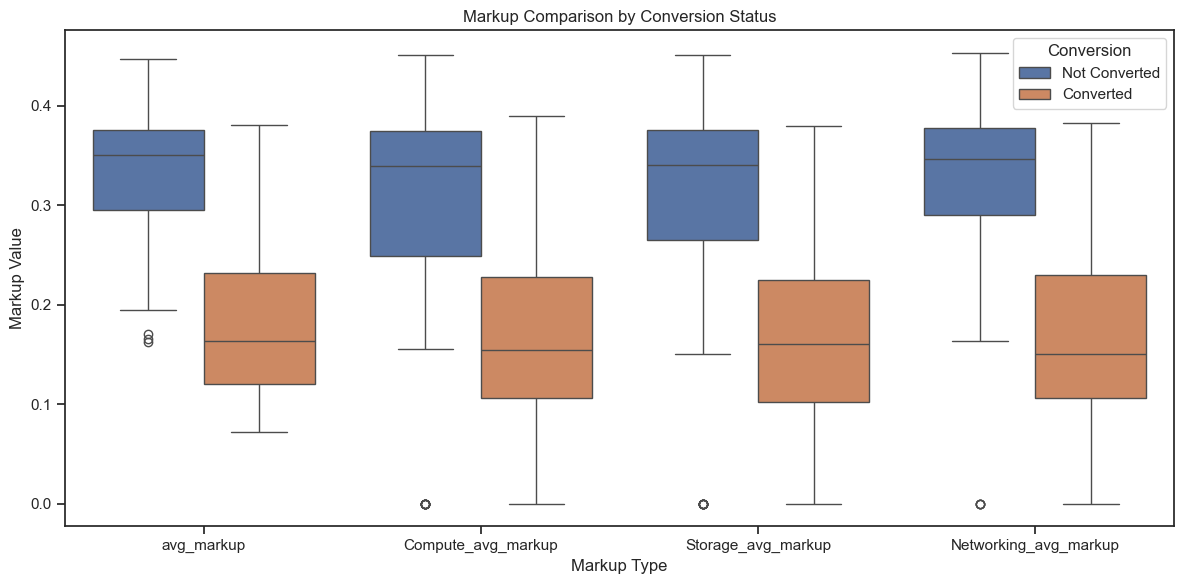

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select all markup columns you want to compare
markup_cols = [
    'avg_markup',
    'Compute_avg_markup',
    'Storage_avg_markup',
    'Networking_avg_markup'
]

# Melt the dataframe to long format
df_melted = quote_features.melt(
    id_vars='quote_converted',
    value_vars=markup_cols,
    var_name='markup_type',
    value_name='markup_value'
)

# Convert 0/1 to labels (optional)
df_melted['Conversion'] = df_melted['quote_converted'].map({0: 'Not Converted', 1: 'Converted'})

# Make the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_melted,
    x='markup_type',
    y='markup_value',
    hue='Conversion'
)

plt.title("Markup Comparison by Conversion Status")
plt.xlabel("Markup Type")
plt.ylabel("Markup Value")
plt.tight_layout()
plt.show()


#### Use box plot visually validates SHAP + model findings: Compute category shows the strongest separation. Look at Compute_avg_markup
#### Compute is the most price-sensitive category. Higher compute markup heavily reduces the likelihood of winning.

In [94]:
tradeoff_markup = X_train_o['avg_markup']  # get avg_markup before scale
tradoff_y_prob = final_model_xgb.predict_proba(X_train)[:, 1]

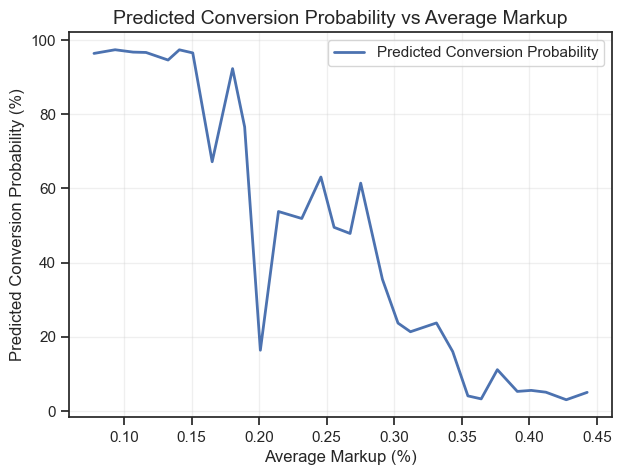

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Combine and sort by markup
df_tradeoff = pd.DataFrame({
    'avg_markup': tradeoff_markup,
    'predicted_prob': tradoff_y_prob
}).sort_values('avg_markup')

# Bin or smooth for clearer curve (optional but helpful)
df_smooth = (
    df_tradeoff
    .groupby(pd.cut(df_tradeoff['avg_markup'], bins=30))
    .mean()
    .dropna()
)

# Plot the empirical curve
plt.figure(figsize=(7,5))
plt.plot(df_smooth['avg_markup'], df_smooth['predicted_prob']*100, label='Predicted Conversion Probability', lw=2)
plt.xlabel('Average Markup (%)', fontsize=12)
plt.ylabel('Predicted Conversion Probability (%)', fontsize=12)
plt.title('Predicted Conversion Probability vs Average Markup', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


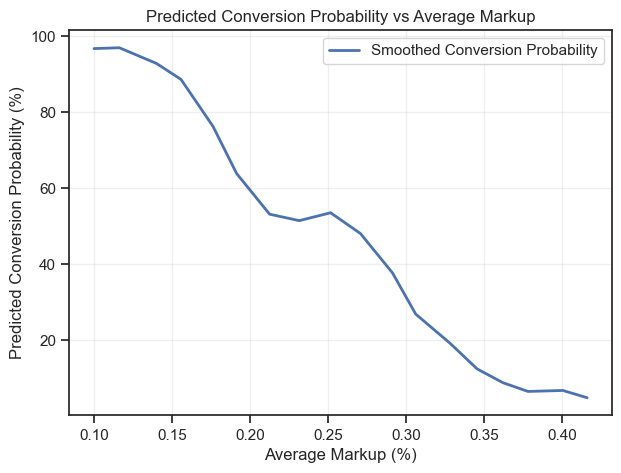

In [102]:
# Increase bins for finer grouping
df_smooth = (
    df_tradeoff
    .groupby(pd.cut(df_tradeoff['avg_markup'], bins=20))  # use more bins
    .mean()
    .dropna()
)

# Rolling mean to smooth out jitter
df_smooth['smoothed_prob'] = df_smooth['predicted_prob'].rolling(window=3, center=True).mean()

plt.figure(figsize=(7,5))
plt.plot(df_smooth['avg_markup'], df_smooth['smoothed_prob']*100, lw=2, label='Smoothed Conversion Probability')
plt.xlabel('Average Markup (%)')
plt.ylabel('Predicted Conversion Probability (%)')
plt.title('Predicted Conversion Probability vs Average Markup')
plt.grid(alpha=0.3)
plt.legend()
plt.show()
